In [1]:
import numpy as np # v. 1.22.1
import matplotlib.pyplot as plt # v. 3.7.5
import os
import pandas as pd # v. 1.5.3
import pykrev as pk # v. 1.2.4

import sys
sys.path.append('../mchem_functions')
import ms_functions_and_defs as msf

In [2]:
ms_dir = '../../Data/MS_data'

intensity_ordination_table_path = 'CSV_files/processed_csv_data_dir/overall_intensity_ordination_table.csv'
mz_ordination_table_path = 'CSV_files/processed_csv_data_dir/overall_mz_ordination_table.csv'

image_format = 'svg' #jpeg, png, svg...
cmap = 'summer'

mz_limits = [200,800]

In [3]:
# Change directory to the ms_dir
try: os.chdir(ms_dir)
except FileNotFoundError: pass
plots_dir = 'plots'
if not os.path.exists(plots_dir): os.mkdir(plots_dir)

if not image_format.startswith('.'): image_format = '.' + image_format

In [4]:
df_intensity = pd.read_csv(intensity_ordination_table_path,index_col=0)
df_intensity = df_intensity[df_intensity['replicate_y/n']==0].drop(['replicate_y/n'],axis=1)

df_mz = pd.read_csv(mz_ordination_table_path,index_col=0)
df_mz = df_mz[df_mz['replicate_y/n']==0].drop(['replicate_y/n'],axis=1)

In [5]:
assert np.all(df_mz.index == df_intensity.index), 'The samples (indices) in df_mz and df_intensity must be the same'
sample_names = df_mz.index

assert np.all(df_mz.columns == df_intensity.columns), 'The compounds (columns headers) in df_mz and df_intensity must be the same'
molecformulae_strs = df_mz.columns

In [6]:
# filter the values based on the m/z restraints given before
if mz_limits != []:
    avg_mz = np.nanmean(df_mz, axis=0)
    # mz_filter = np.where((avg_mz>np.min(mz_limits))&(avg_mz<np.max(mz_limits)))
    filtered_formulae = molecformulae_strs[np.where((avg_mz>np.min(mz_limits))&(avg_mz<np.max(mz_limits)))]
    df_mz = df_mz[filtered_formulae]
    df_intensity = df_intensity[filtered_formulae]

In [7]:
info_dicts = []
for f in molecformulae_strs:
    info_dicts.append(msf.MolecFormulaDict(f))

In [8]:
# Fill out the missing elements in those compound that don't have them for later ease
info_dicts = np.array(info_dicts)
all_elements = []

for d in info_dicts:
    for k in d.keys():
        if k not in all_elements: all_elements.append(k)

for i in range(len(info_dicts)):
    for e in all_elements:
        if e not in info_dicts[i].keys():
            info_dicts[i][e] = 0

In [9]:
# make dataframe

for i in range(len(info_dicts)):
    if i == 0:
        info_df = pd.DataFrame(info_dicts[i], index=[molecformulae_strs[i]])
    else:
        info_df = pd.concat([info_df, pd.DataFrame(info_dicts[i], index=[molecformulae_strs[i]])],axis=0)

# info_df

In [10]:
for e in all_elements:
    if e != 'C':
        info_df[f'{e}/C'] = info_df[e] / info_df['C']
        info_df[f'{e}/C'] = info_df[e] / info_df['C']
        info_df[f'{e}/C'] = info_df[e] / info_df['C']

info_df['DBE'] = msf.dbe(info_df['C'],info_df['H'],info_df['N'])
info_df['DBE-O'] = msf.dbe_o(info_df['C'],info_df['H'],info_df['N'],info_df['O'])
info_df['AI'] = msf.AI(info_df['C'],info_df['H'],info_df['N'],info_df['O'],info_df['S'],np.zeros(len(info_df['C'])))

kmass_list = []
kmd_list = []
z_list = []
for i in range(len(info_dicts)):
    kmass, kmd, z = msf.kendrick_analysis(info_dicts[i])
    kmass_list.append(kmass)
    kmd_list.append(kmd)
    z_list.append(z)

info_df['Kendrick_mass'] = kmass_list
info_df['KMD'] = kmd_list
info_df['z*'] = z_list
# info_df

c:\Users\s2017658\OneDrive - University of Edinburgh\Y5\Y5_Code\ms_processing\../mchem_functions\ms_functions_and_defs.py:214: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


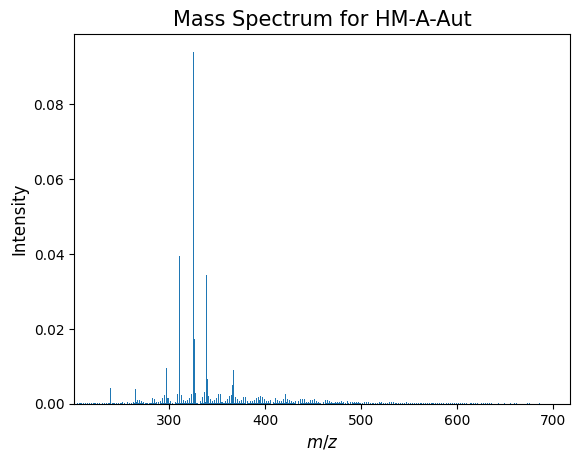

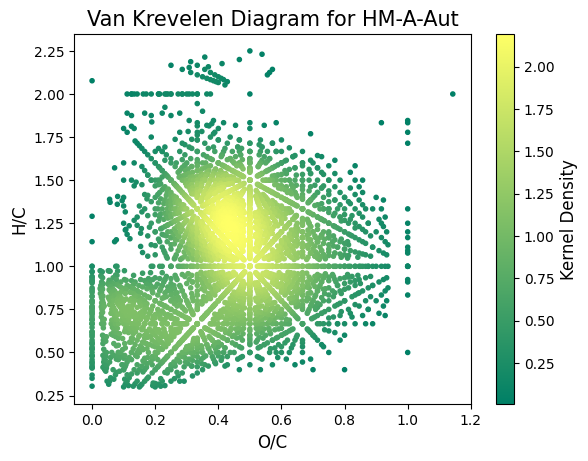

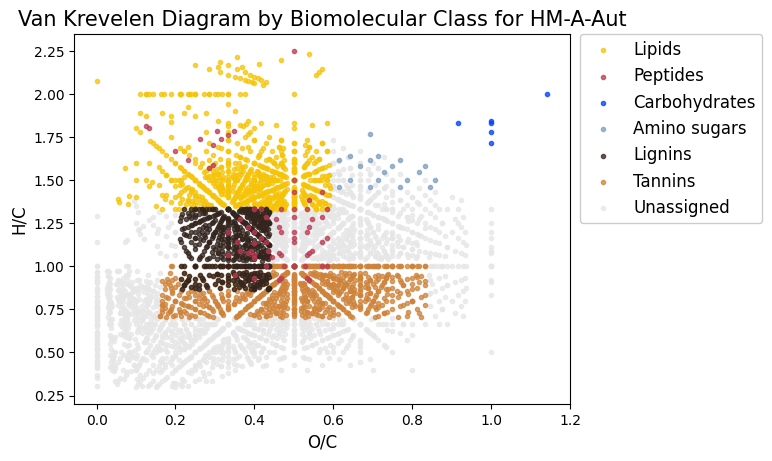

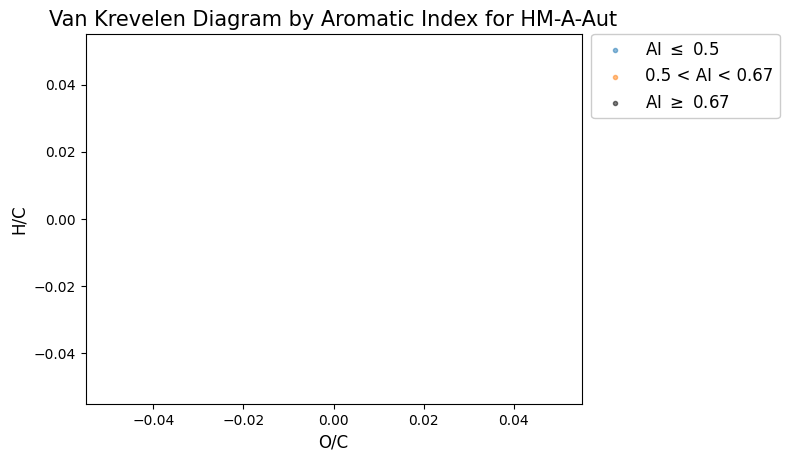

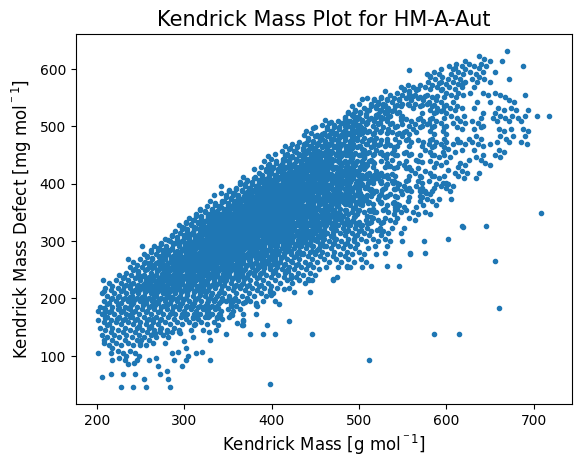

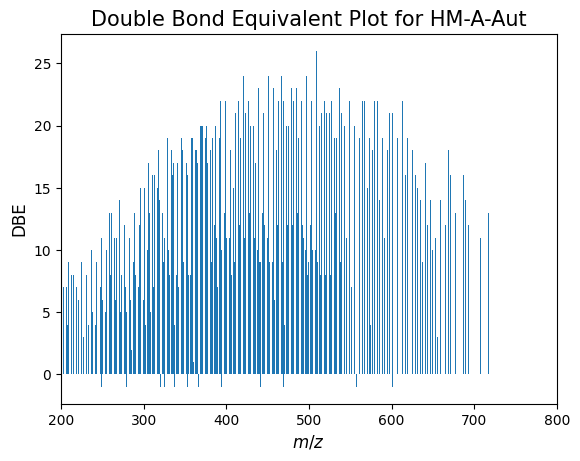

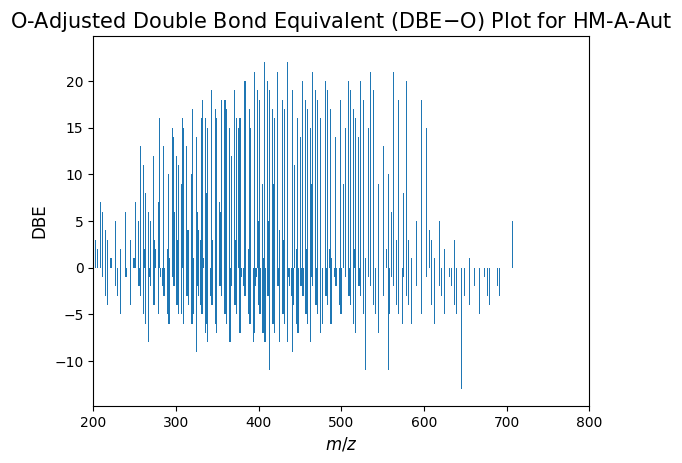

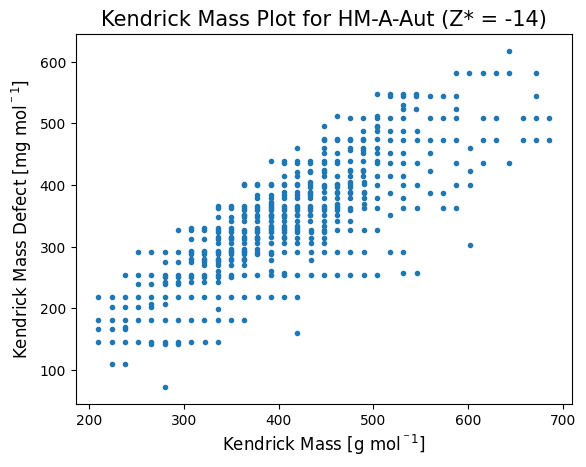

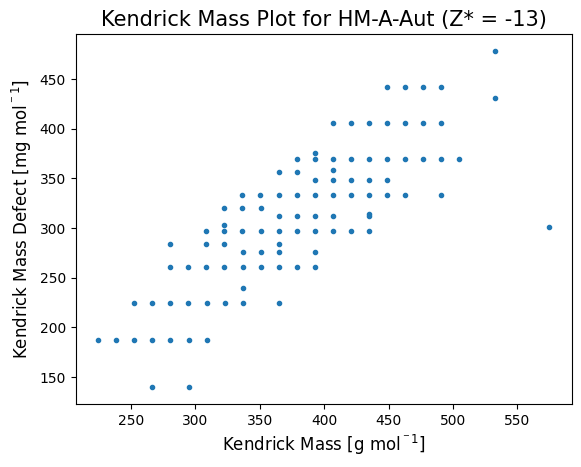

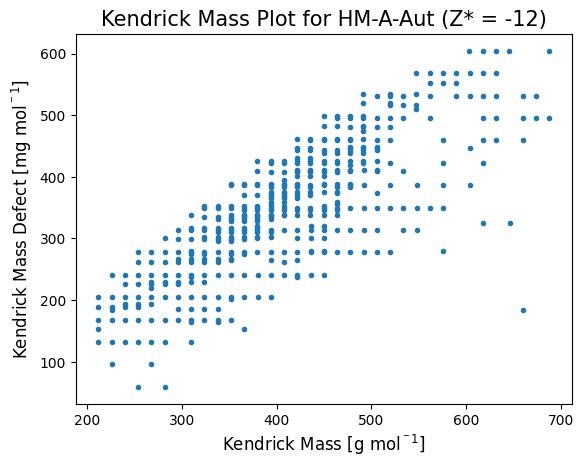

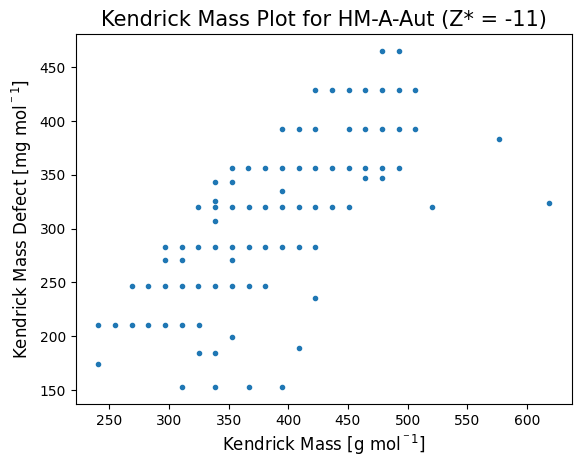

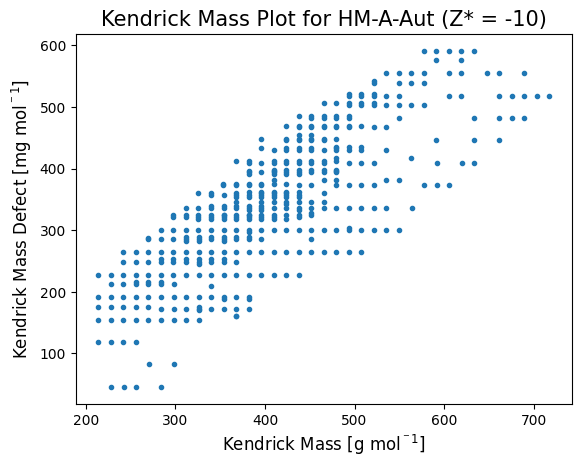

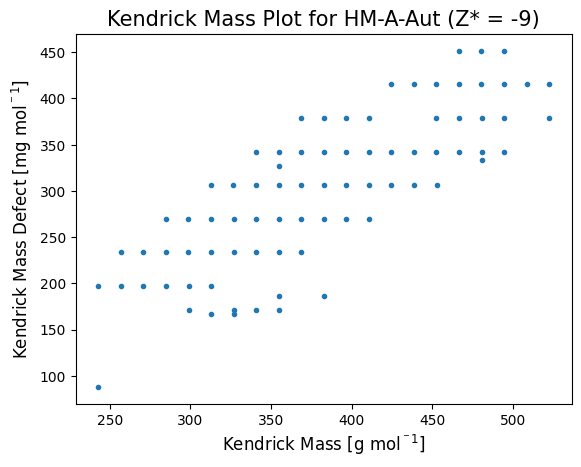

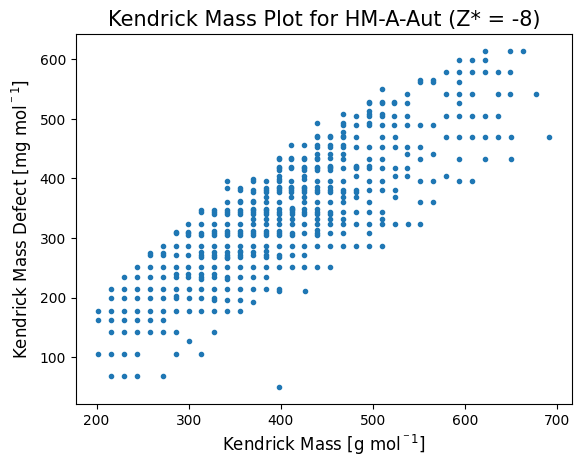

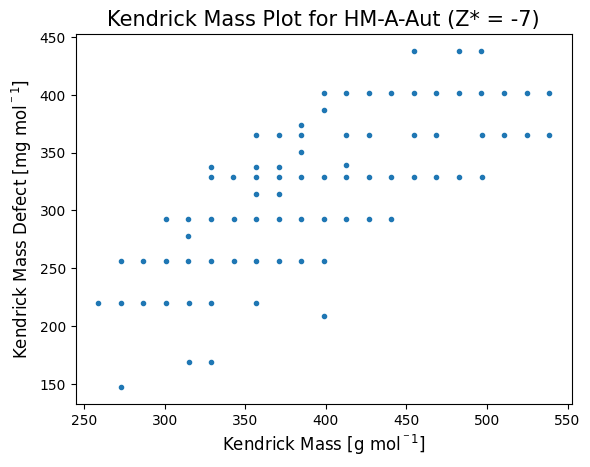

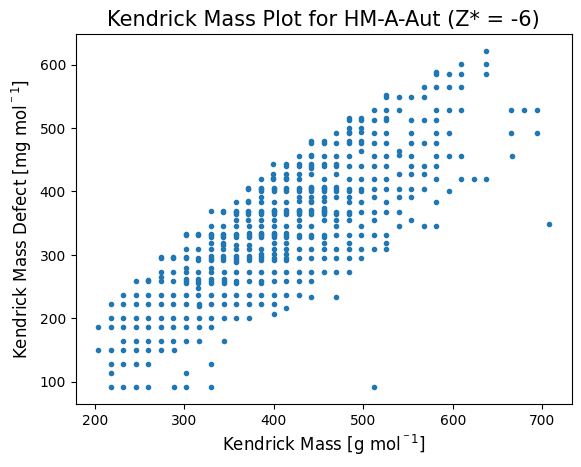

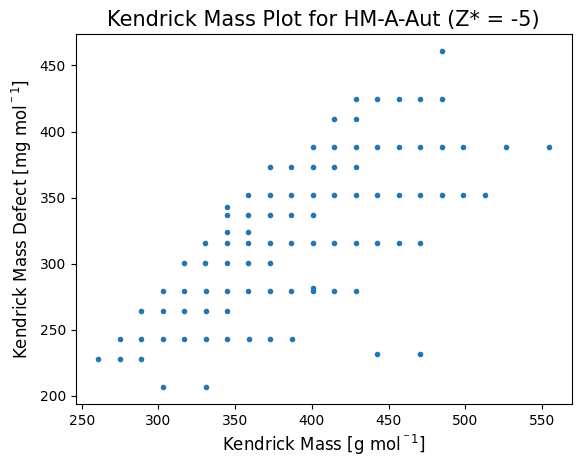

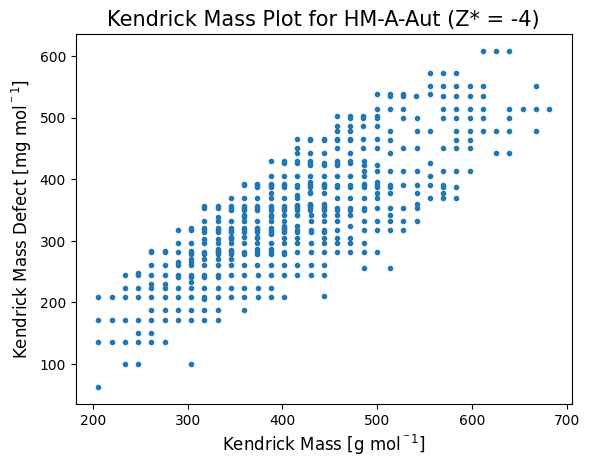

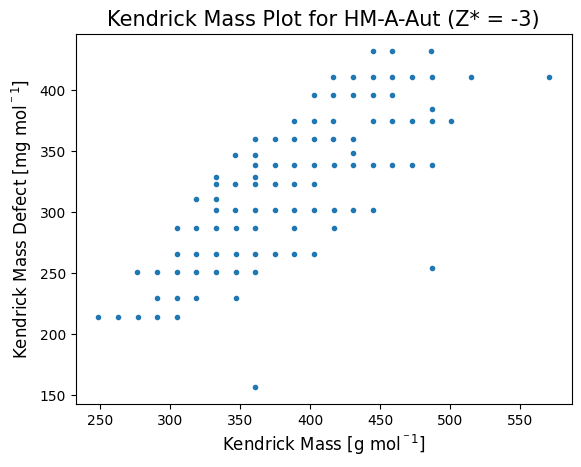

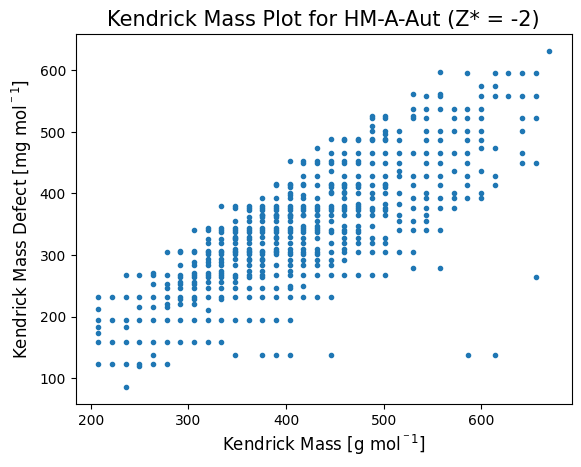

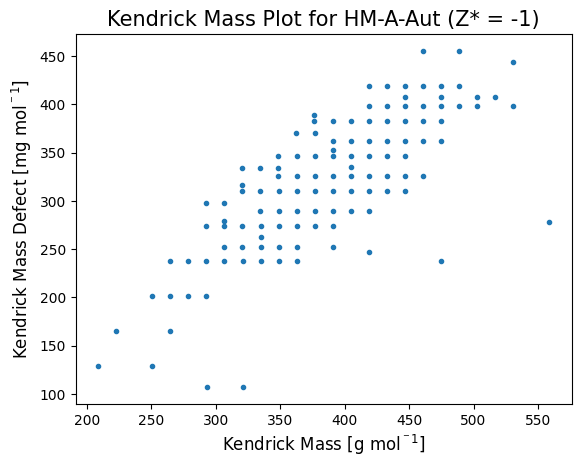

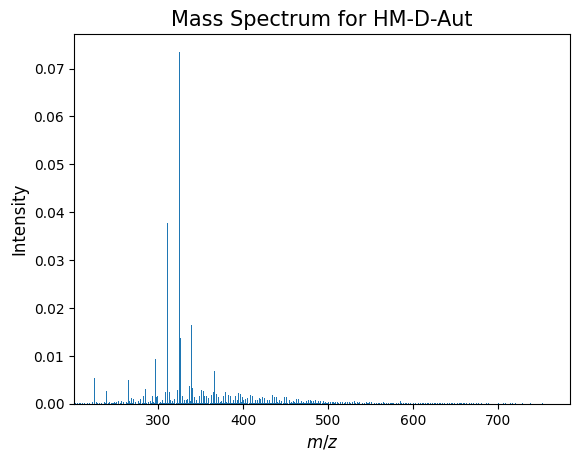

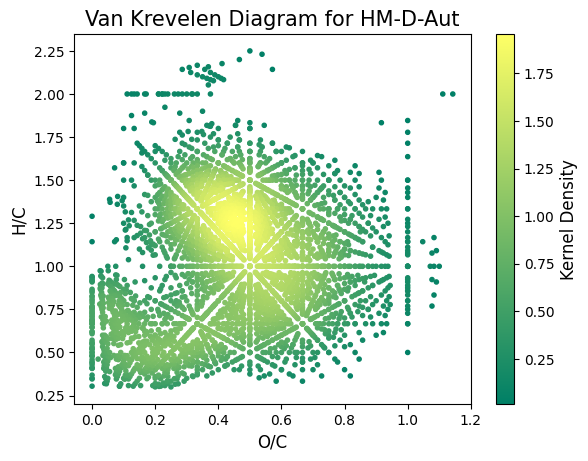

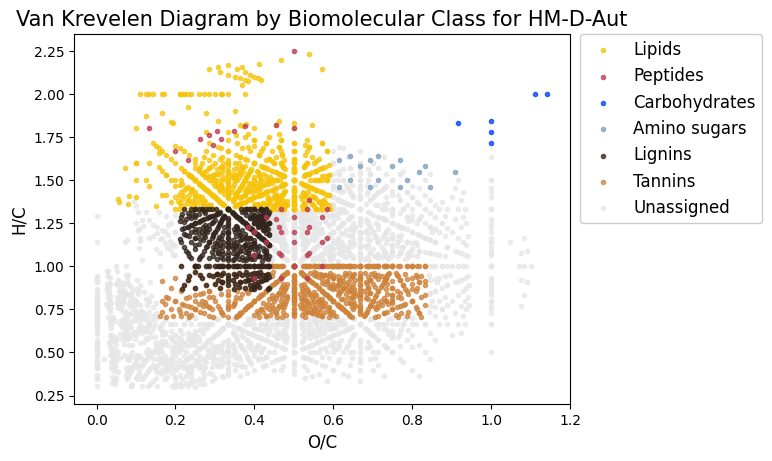

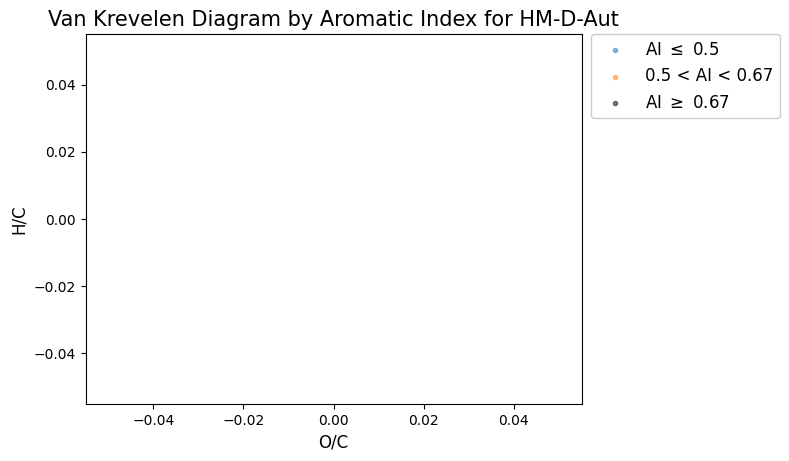

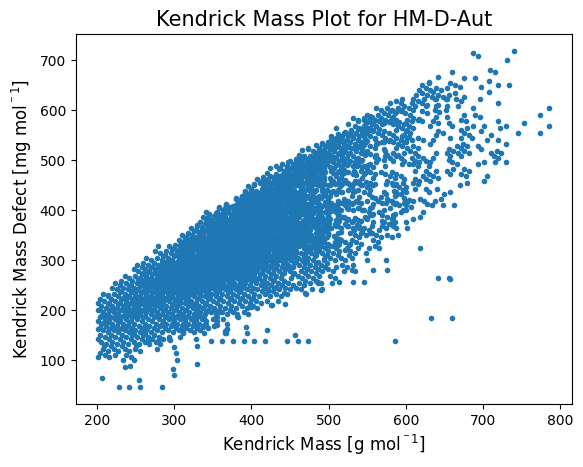

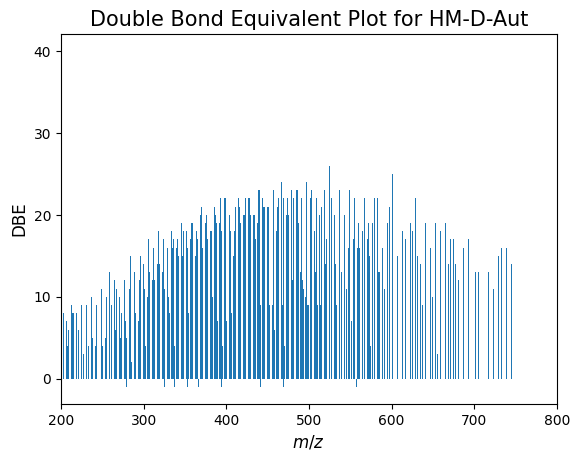

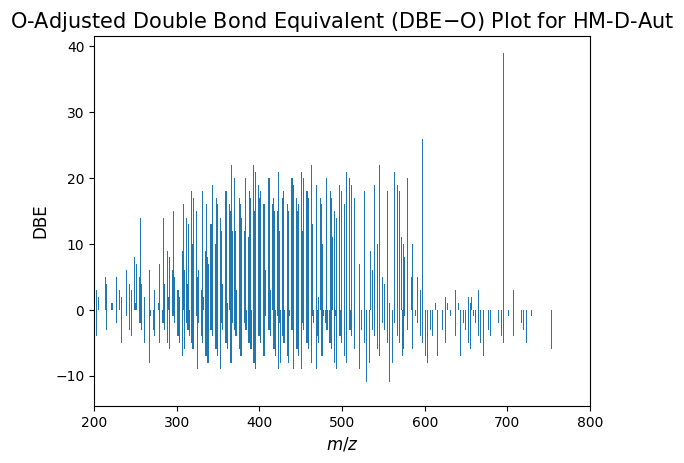

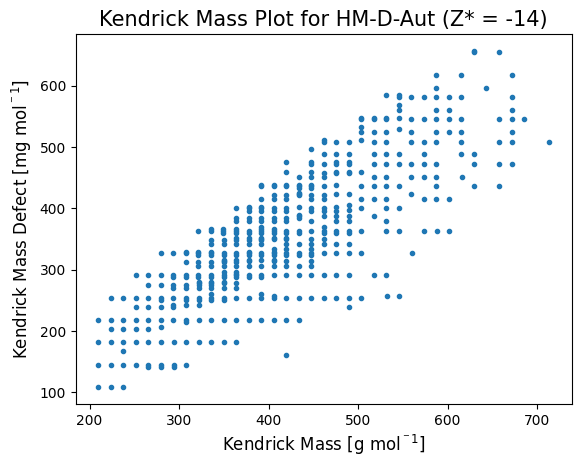

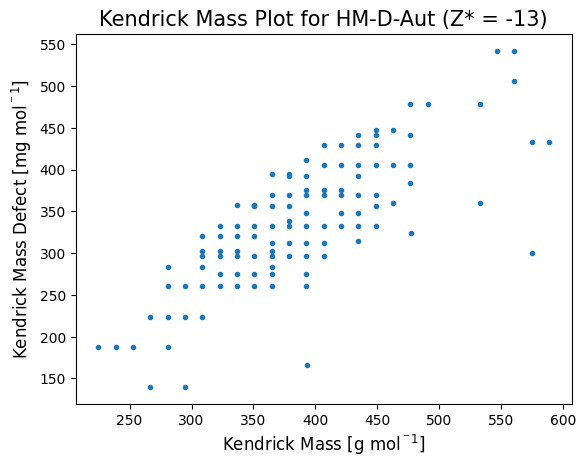

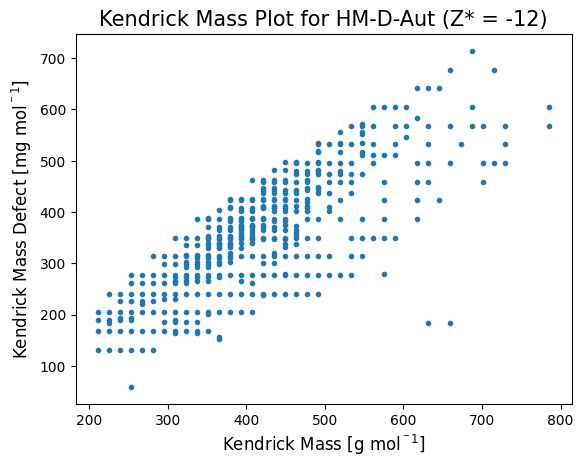

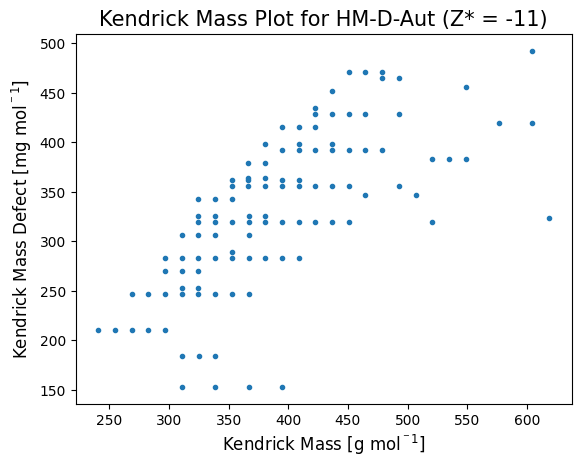

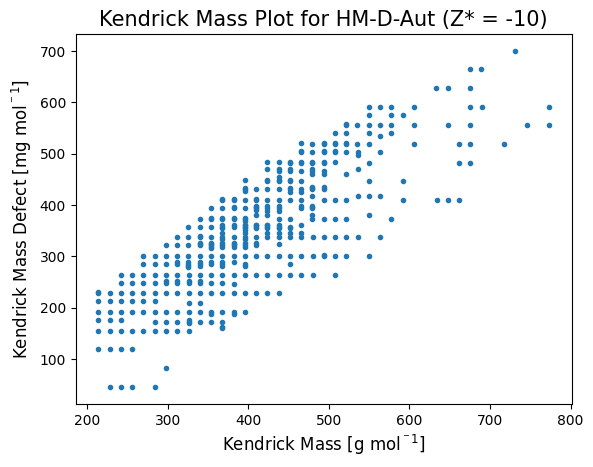

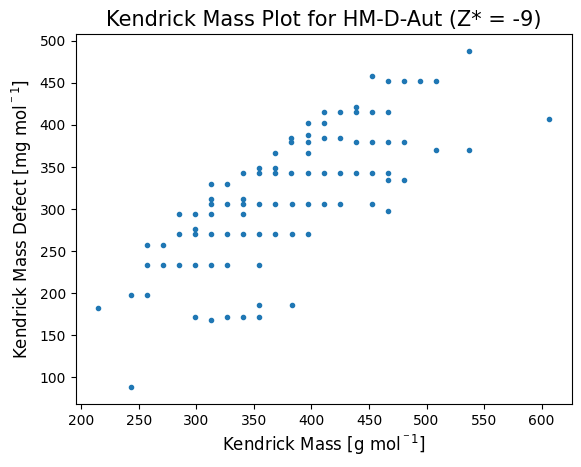

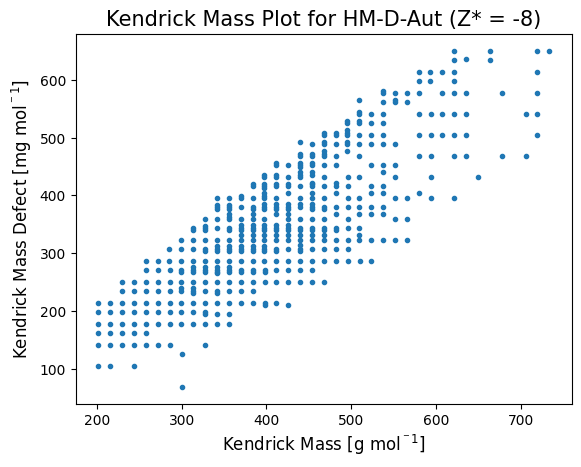

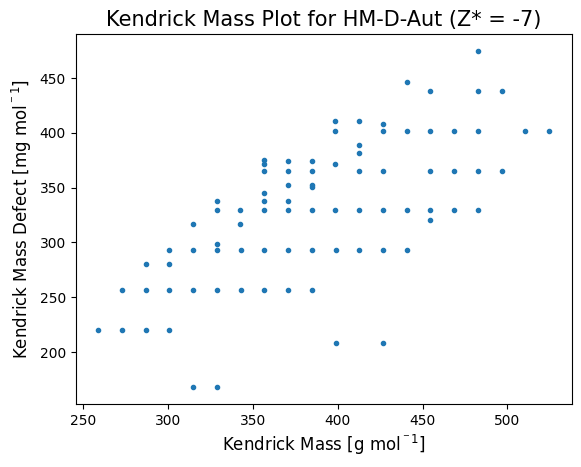

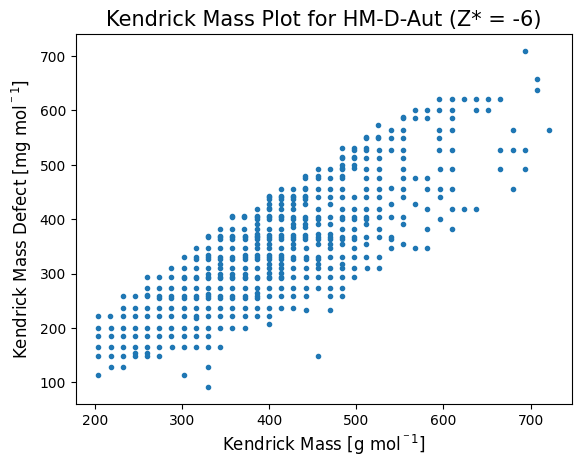

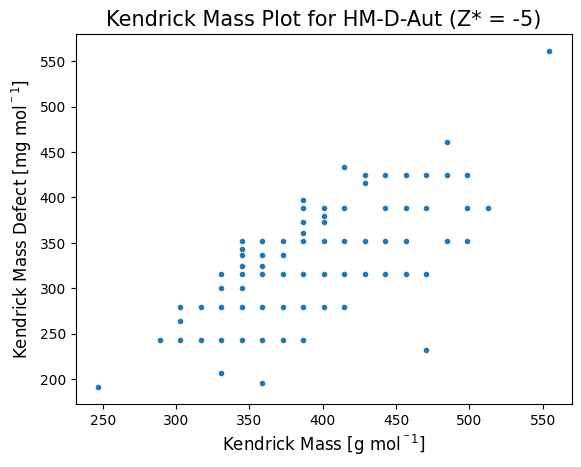

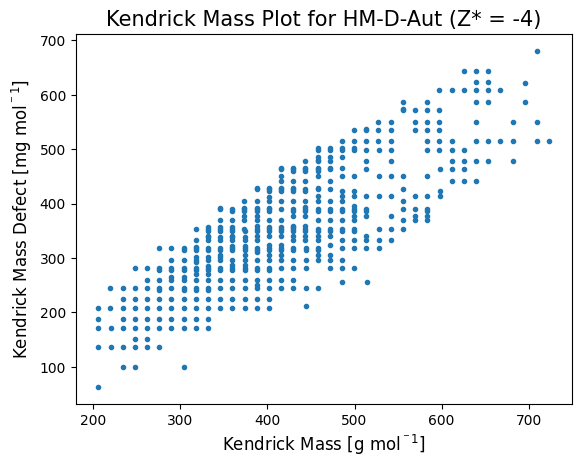

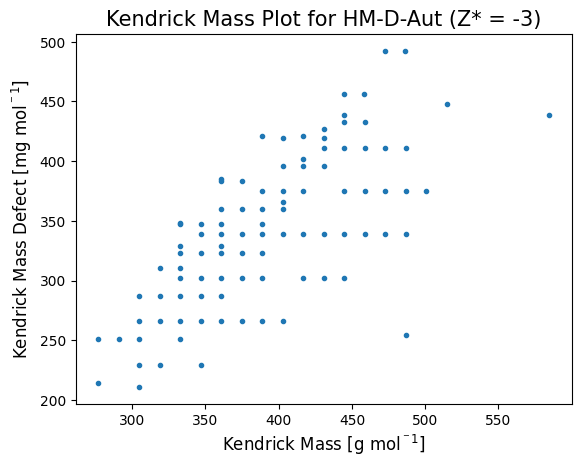

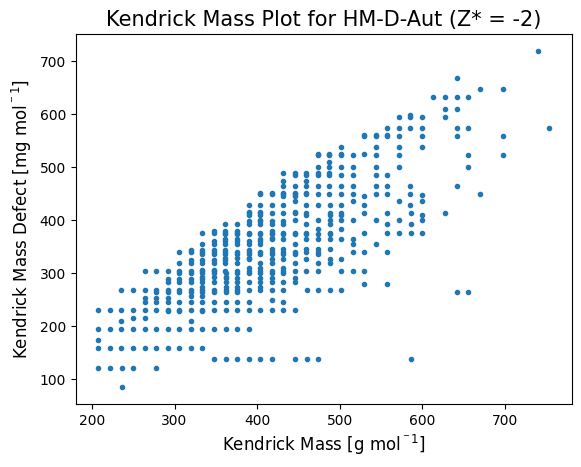

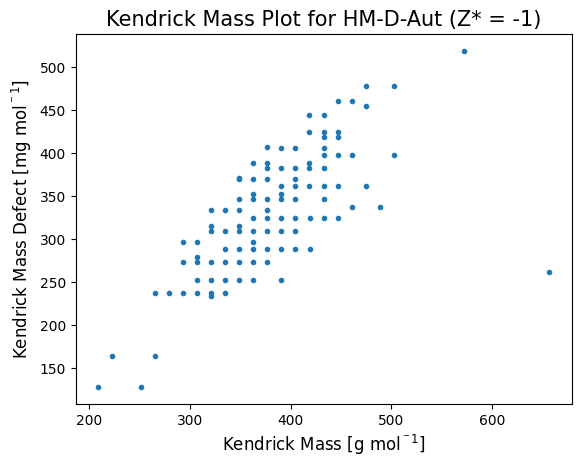

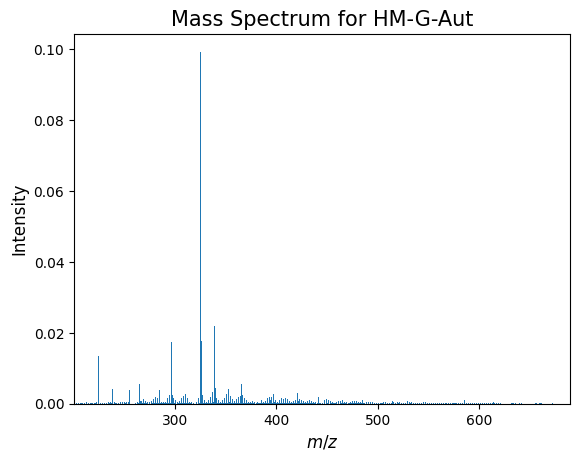

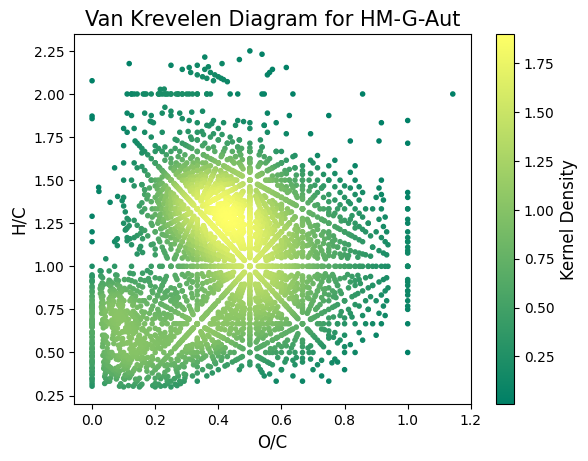

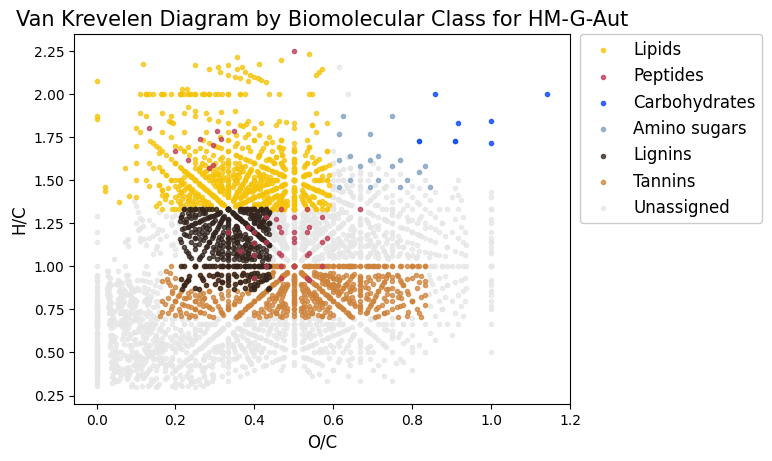

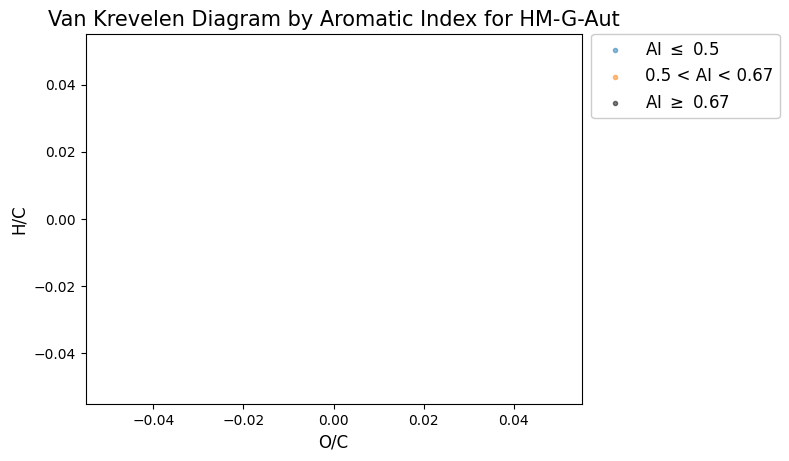

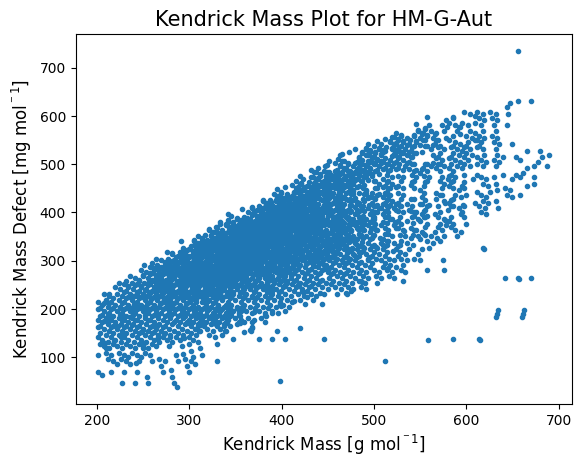

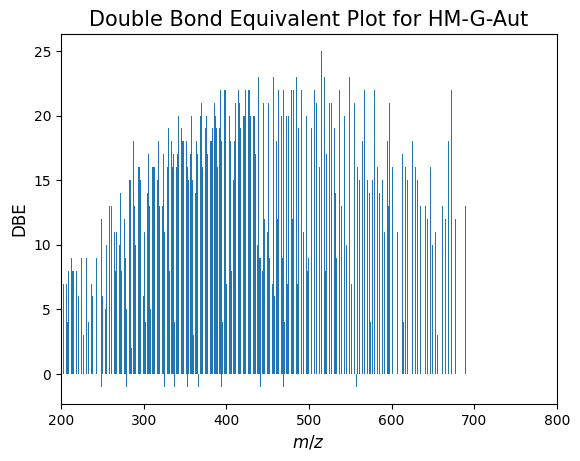

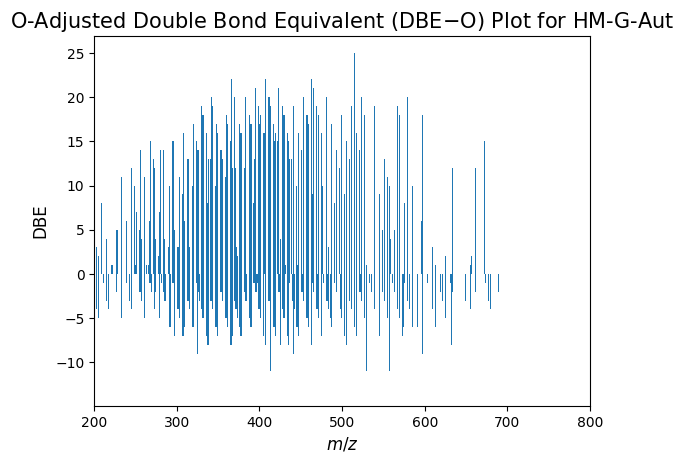

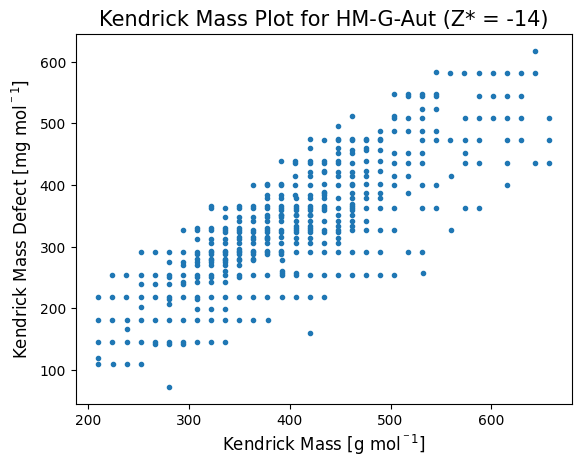

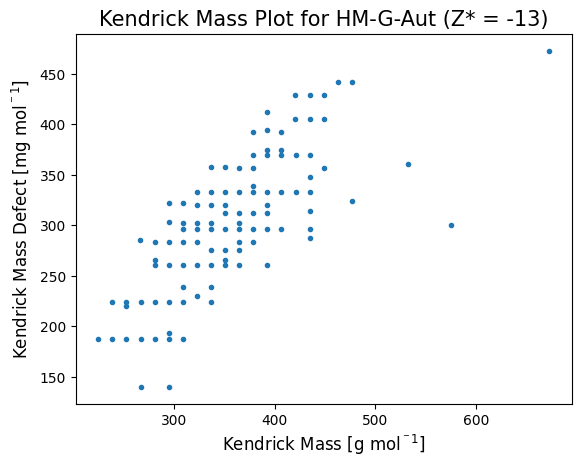

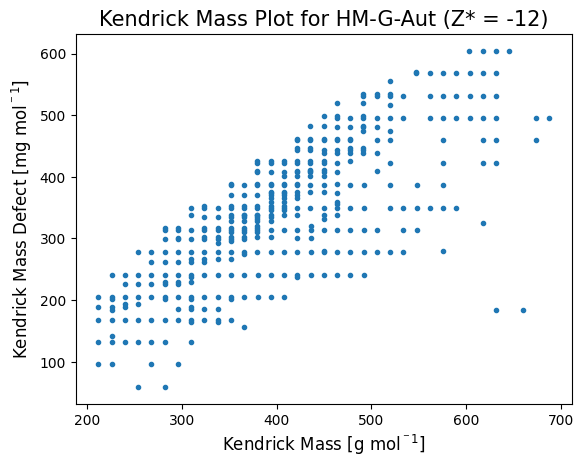

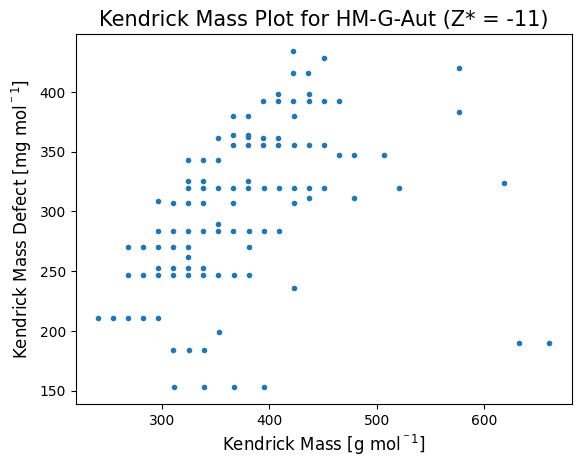

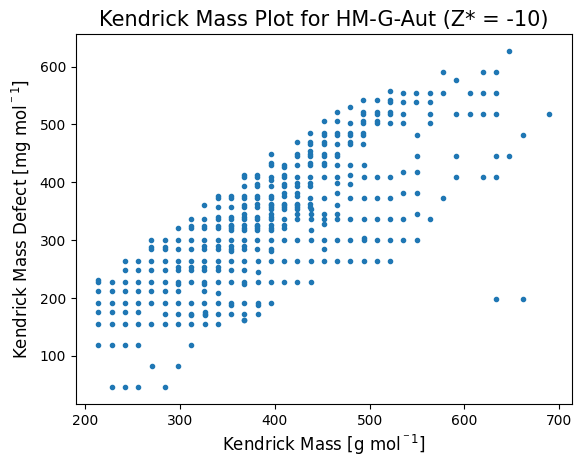

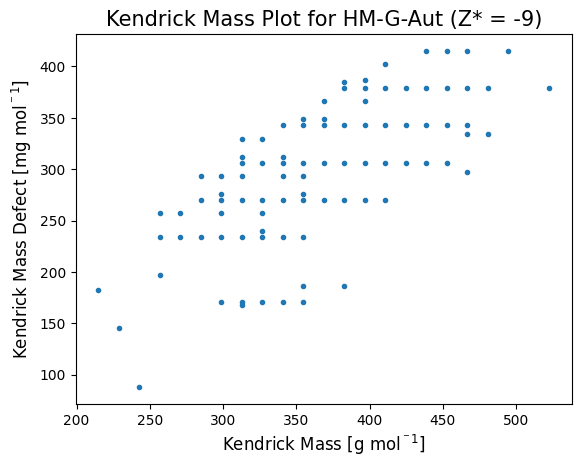

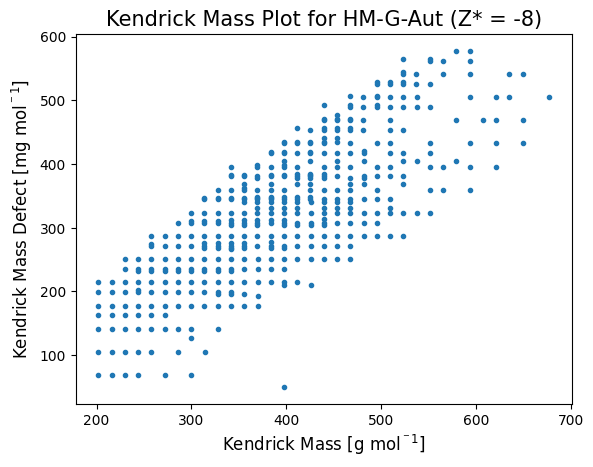

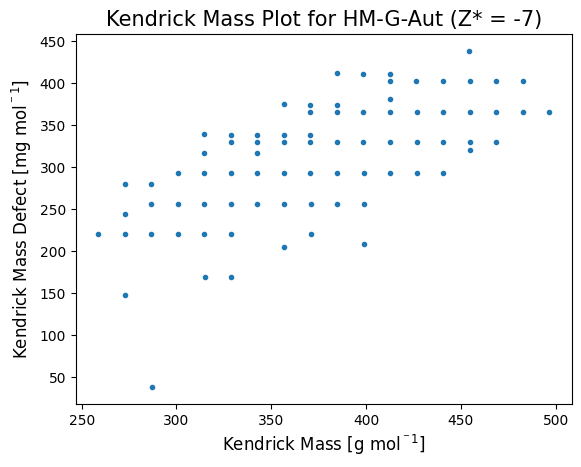

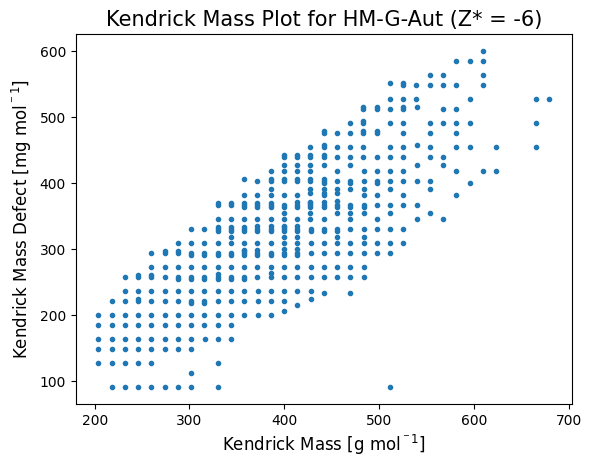

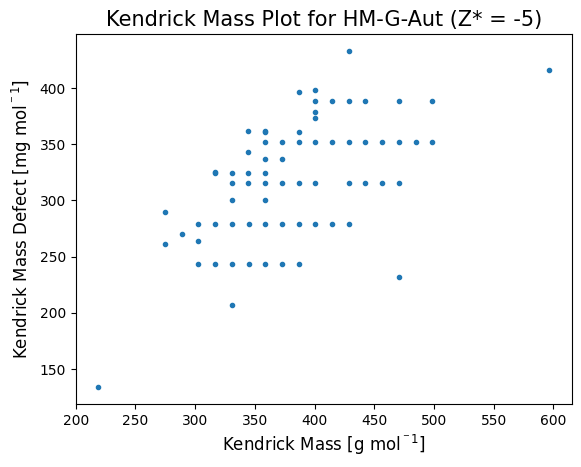

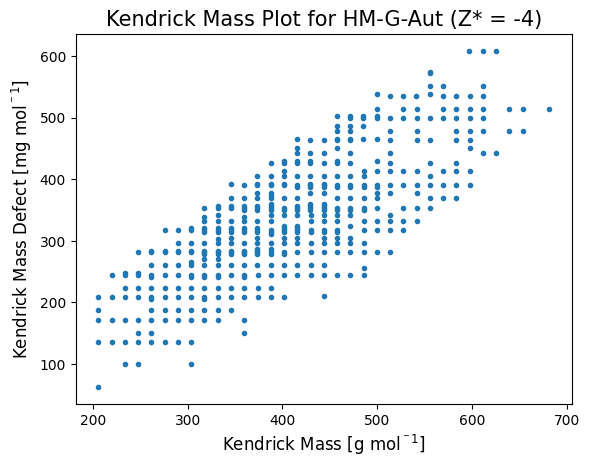

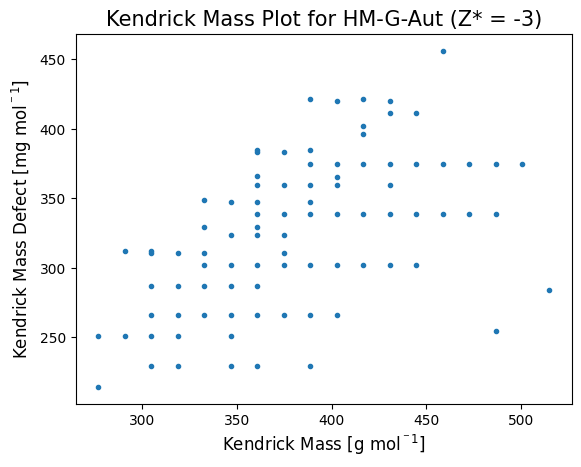

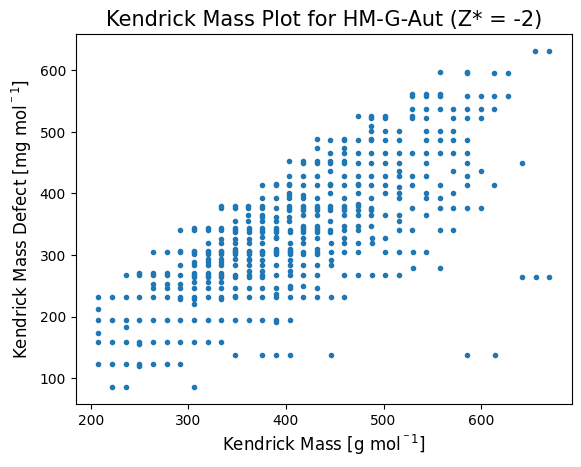

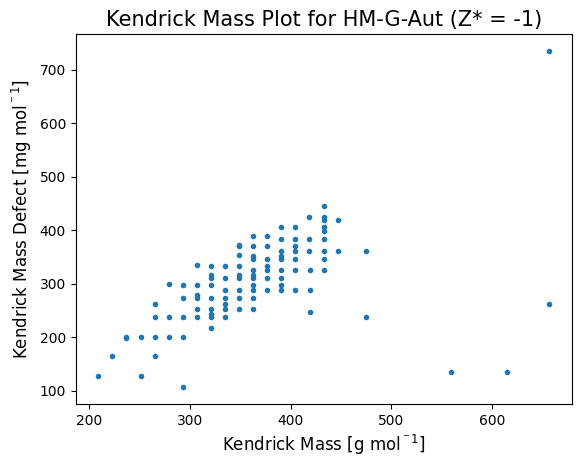

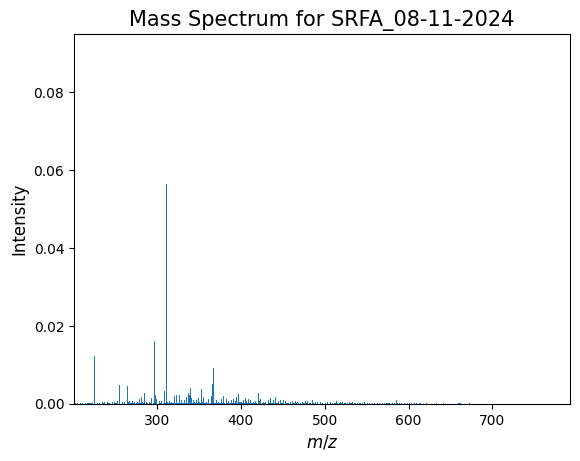

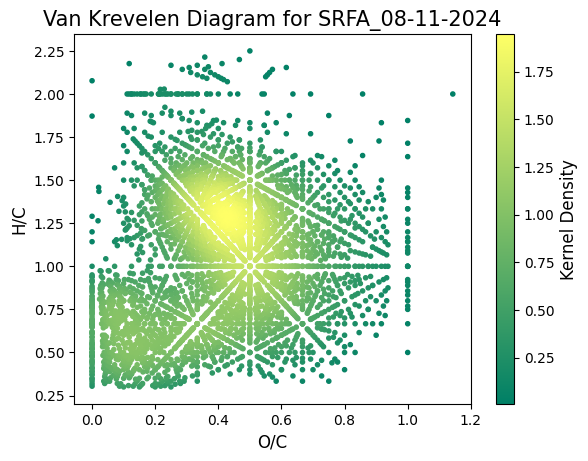

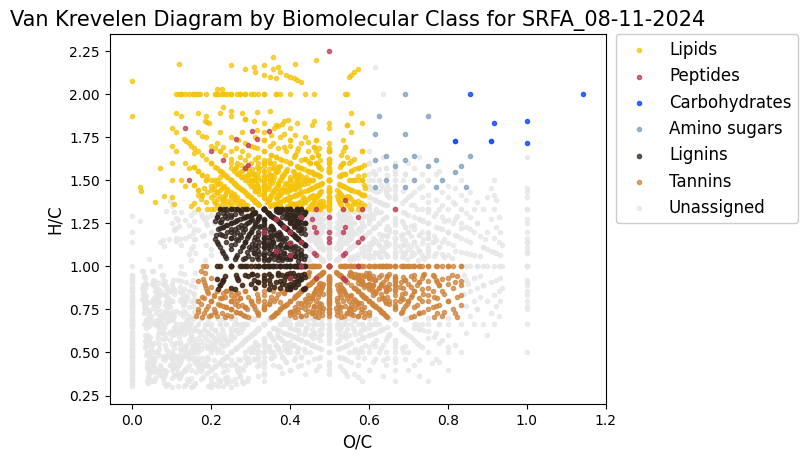

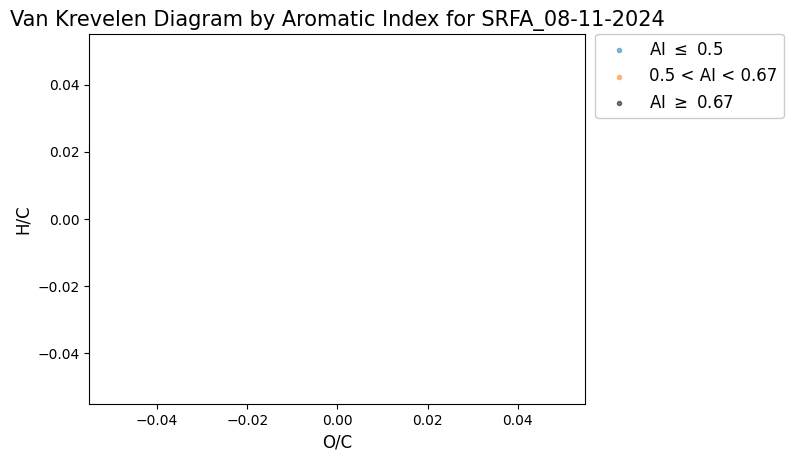

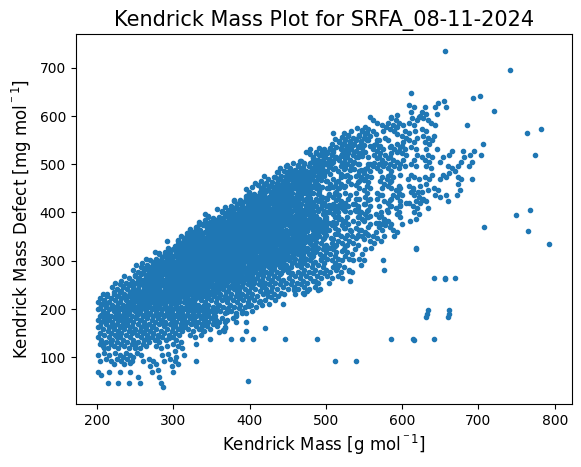

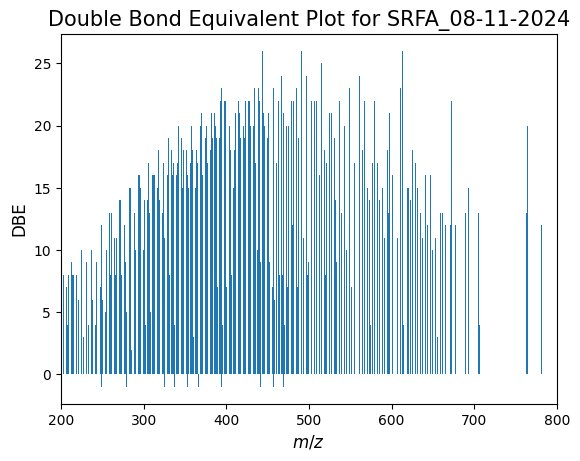

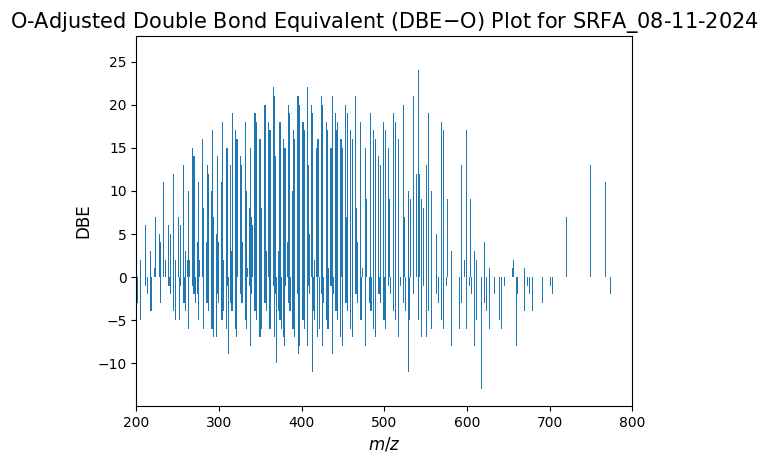

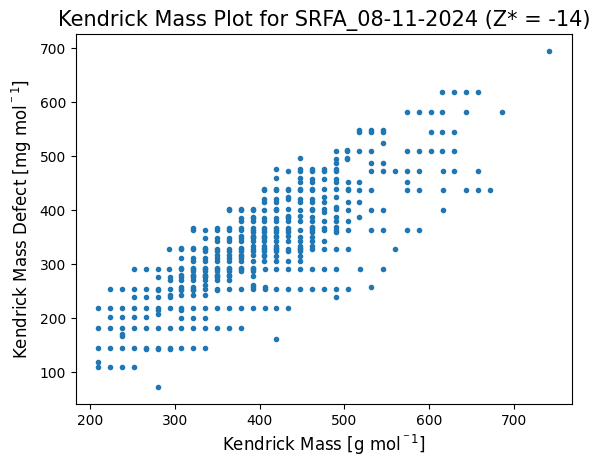

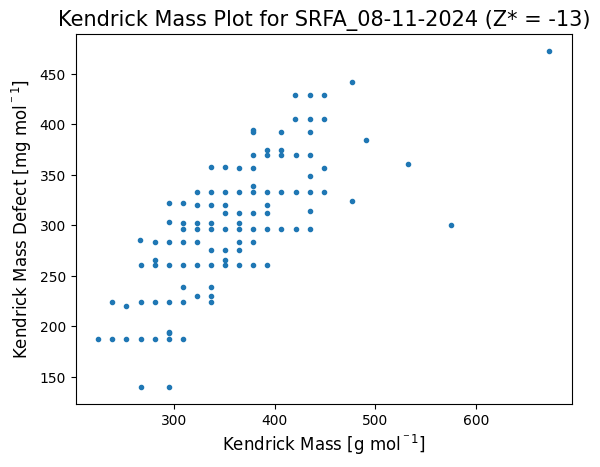

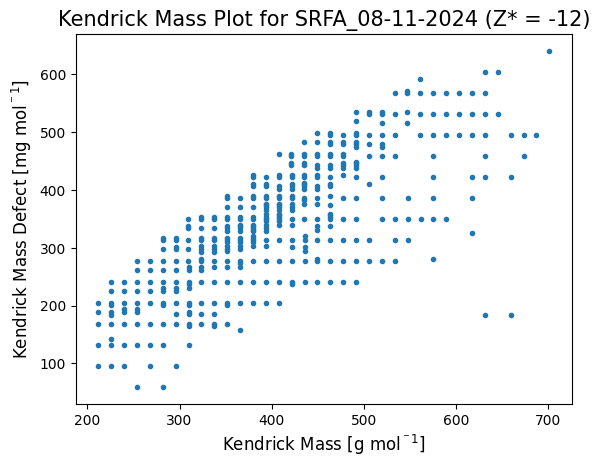

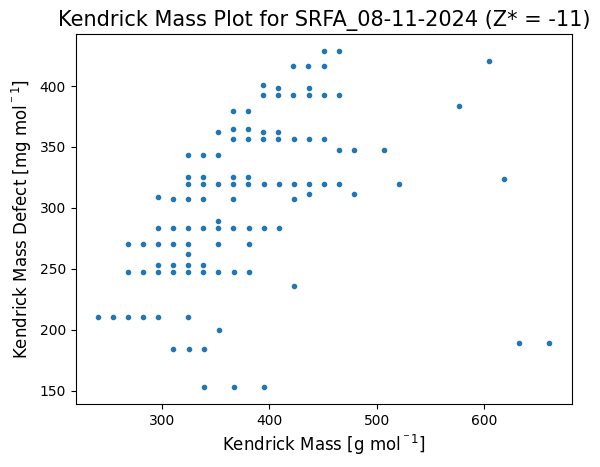

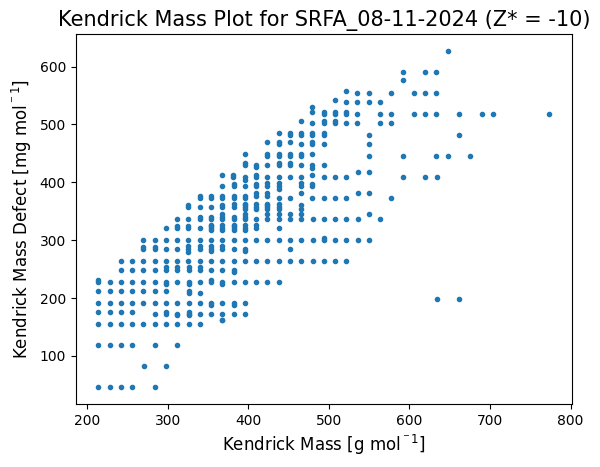

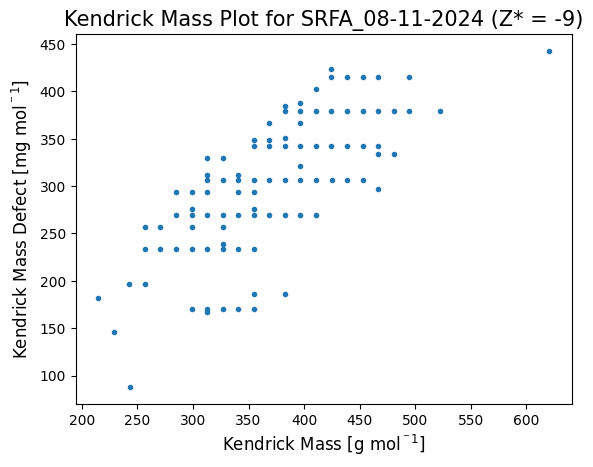

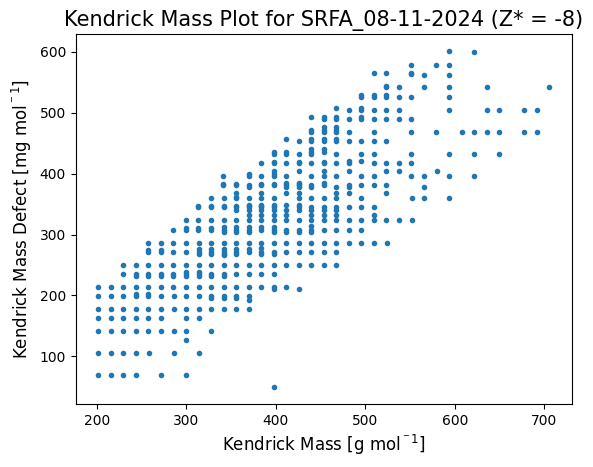

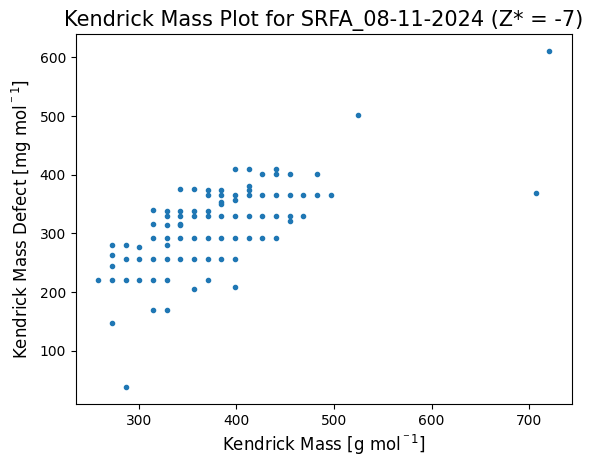

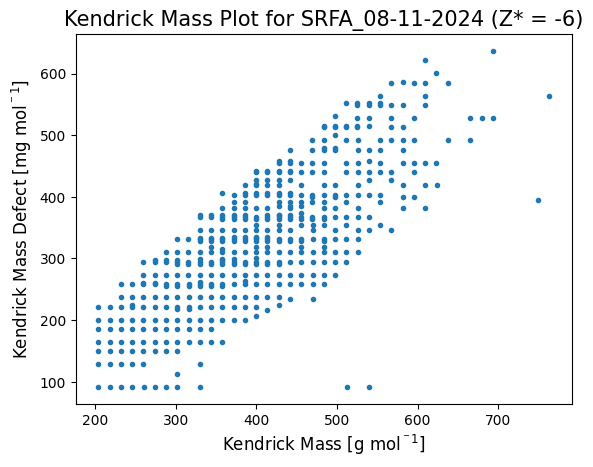

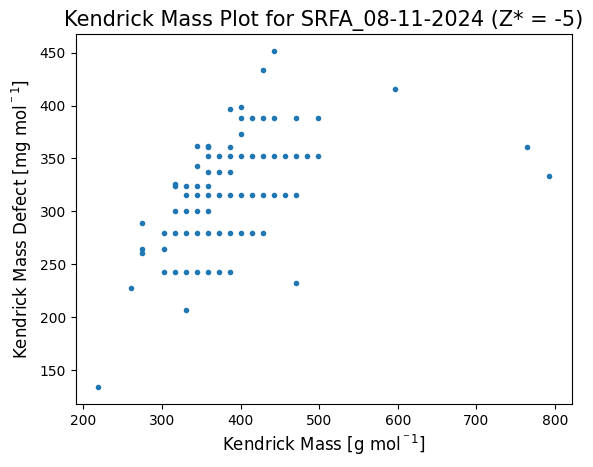

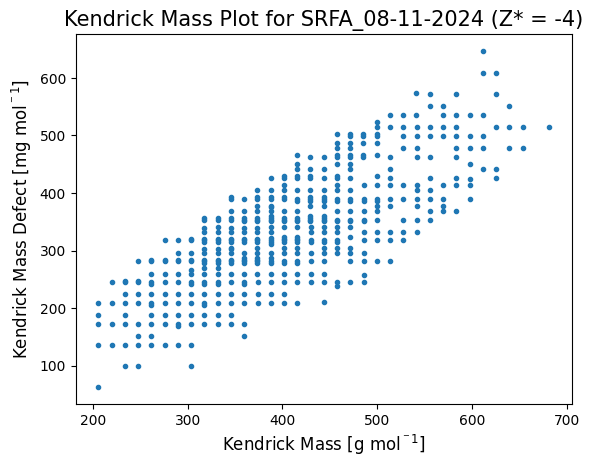

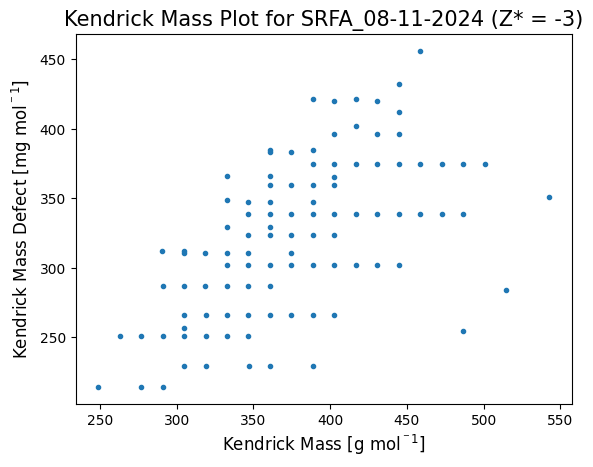

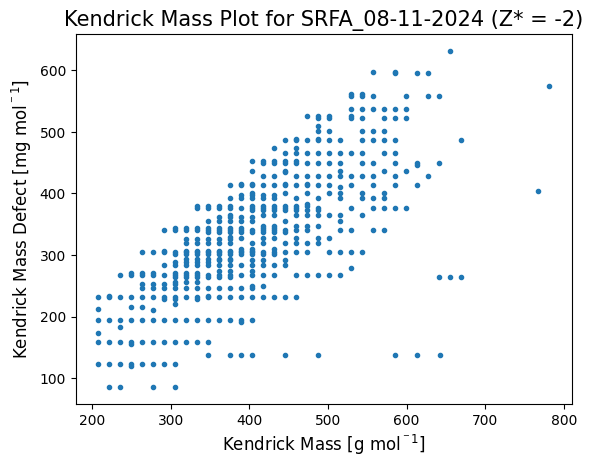

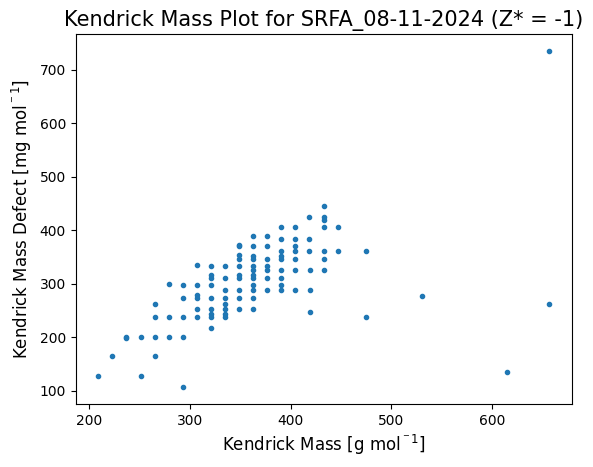

In [11]:
for name in sample_names:
    # only select the molecules in the dataframe that are present in that sample

    selected_df = info_df.copy().loc[df_mz.loc[name].copy().dropna().index]

    # create the directories needed unless already there
    sample_dir = f'{plots_dir}/{name}'
    sample_kendrick_dir = f'{sample_dir}/kendrick_plots'
    if not os.path.exists(sample_dir): os.mkdir(sample_dir)
    if not os.path.exists(sample_kendrick_dir): os.mkdir(sample_kendrick_dir)

    selected_mz = df_mz.loc[name].copy().dropna().values
    selected_intensity = df_intensity.loc[name].copy().dropna().values

    # plot the figures and save them
    msf.massspectrum_plot(selected_mz,selected_intensity,
                          title=f'Mass Spectrum for {name}',
                          save_path=f"{sample_dir}/{name}_mass_spectrum{image_format}")

    msf.density_vk_diagram(selected_df,cmap=cmap,
                           title=f'Van Krevelen Diagram for {name}',
                           save_path=f"{sample_dir}/{name}_vkd_density{image_format}")

    msf.vk_molecclass(selected_df,alpha=0.75,
                      title=f'Van Krevelen Diagram by Biomolecular Class for {name}',
                      save_path=f"{sample_dir}/{name}_vkd_molecclass{image_format}")

    msf.vk_ai(selected_df,selected_df['AI'],
              title=f'Van Krevelen Diagram by Aromatic Index for {name}',
              save_path=f"{sample_dir}/{name}_vkd_ai{image_format}")
    
    msf.kendrick_plot(selected_df['Kendrick_mass'].to_numpy(),selected_df['KMD'].to_numpy(),
                      title=f'Kendrick Mass Plot for {name}',
                      save_path=f"{sample_dir}/{name}_kendrick_plot{image_format}")
    
    msf.dbe_plot(selected_mz,selected_df['DBE'],xlim=mz_limits,width=0.5,
                 title=f'Double Bond Equivalent Plot for {name}',
                 save_path=f"{sample_dir}/{name}_dbe_plot{image_format}")

    msf.dbe_plot(selected_mz,selected_df['DBE-O'],xlim=mz_limits,width=0.5,
                 title=f'O-Adjusted Double Bond Equivalent (DBE$-$O) Plot for {name}',
                 save_path=f"{sample_dir}/{name}_dbe-o_plot{image_format}")

    z_unique = np.unique(selected_df['z*'])
    for z in z_unique:
        msf.kendrick_plot(selected_df['Kendrick_mass'].to_numpy(),selected_df['KMD'].to_numpy(),selected_df['z*'].to_numpy(),z,
                          title=f'Kendrick Mass Plot for {name}', #z* value is inserted by msf.kendrick_plot
                          save_path=f"{sample_kendrick_dir}/{name}_kendrick_plot_z={int(z)}{image_format}")